## CAPRI-CT: Causal Analysis and Predictive Reasoning for Image Quality Optimization in Computed Tomography

Most deep learning models in CT imaging focus on making accurate predictions, such as disease detection or image quality estimation. However, these models often function as black boxes, providing predictions without explaining the underlying causal factors. In healthcare, this lack of interpretability can reduce
trust and clinical applicability. To address this challenge, recent research has explored causal machine learning approaches that uncover how different variables influence each other and affect imaging outcomes. Integrating causal inference with deep learning enables not only accurate predictions but also simulation of what-if scenarios, which is crucial for designing optimized imaging protocols.

Our proposed CAPRI-CT model uniquely focuses on predicting SNR in CT scans by explicitly modeling the causal influence of scan parameters such as voltage, current, and contrast agent.

## Causal DAG:
This figure represents Causal Directed Acrylic Graph (DAG) of our proposed CAPRI-CT model that captures the causal relationships between signal-to-noise ratio (snr) in CT imaging and key observed variables tube voltage (v), tube current (t), and contrast agent type (a) along with latent variable (z).This
causal diagram serves as the foundation for both intervention-based and counterfactual reasoning within the CAPRI-CT framework, enabling the estimation of SNR under different scenarios.


<img src="..\images\capri-ct-dag.png" alt="Causal Graph" width="600"/>


In [ ]:
#######################################################################
# Importing the required libraries for our CAPRI-CT Causal Model
#######################################################################

import os
import pandas as pd
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, WeightedRandomSampler, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pathlib import Path
from scipy.stats import pearsonr


In [8]:
##########################################################################################
# Below is the Class CapriCTDataset 
# Combining the CT image with the metadata using Dataset package
# for SNR prediction
##########################################################################################

class CapriCTDataset(Dataset):
    """
    A custom PyTorch Dataset for CT scan images combined with metadata and target SNR values.

    Each sample consists of a grayscale CT image, encoded metadata (Voltage, Time, Contrast Agent),
    and a corresponding SNR value.

    Parameters
    ----------
    metadata_csv : str
        Path to the CSV file containing metadata for each image.
        Expected columns: 'Filename', 'Voltage', 'Time', 'Classification', 'SNR'.
    
    img_folder_path : str
        Path to the folder containing the CT scan image files.
    
    transform : callable, optional
        Optional transform to be applied on a sample image (e.g., resizing, normalization).

    Attributes
    ----------
    agent_dict : dict
        Mapping of contrast agent labels to integer indices.
    
    voltage_dict : dict
        Mapping of voltage levels to integer indices.
    
    time_dict : dict
        Mapping of scan time values to integer indices.
    """

    def __init__(self, metadata_csv, img_folder_path, transform=None):
        self.img_data = pd.read_csv(metadata_csv)
        self.img_folder = img_folder_path
        self.transform = transform

        # Mappings
        self.agent_dict = {'Iodine': 0, 'BiNPs 50nm': 1, 'BiNPs 100nm': 2}
        self.voltage_dict = {80: 0, 100: 1, 120: 2, 140: 3}
        self.time_dict = {215: 0, 430: 1}

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        row = self.img_data.iloc[idx]

        # Load and transform image
        img_path = os.path.join(self.img_folder, row['Filename'])
        img = Image.open(img_path).convert('L')  
        image = self.transform(img) if self.transform else img

        # Convert categorical fields to indices
        voltage_idx = torch.tensor(self.voltage_dict[row['Voltage']], dtype=torch.long)
        time_idx = torch.tensor(self.time_dict[row['Time']], dtype=torch.long)
        agent_idx = torch.tensor(self.agent_dict[row['Classification']], dtype=torch.long)

        # Target SNR
        snr = torch.tensor(row['SNR'], dtype=torch.float32)

        return image, voltage_idx, time_idx, agent_idx, snr


## Structural Diagram of the CAPRI-CT Causal Aware Model 

<img src="../images/CAPRI-CT.png" alt="Model Diagram" width="800"/>

In [9]:
###############################################################################
# Below is our CAPRI-CT Causal VAE model
###############################################################################

class CapriCTCausalVAEModel(nn.Module):
    """
    A Causal Variational Autoencoder (VAE) model for predicting SNR from CT images and metadata.

    This model combines image features with categorical metadata embeddings (Voltage, Time, Agent)
    and uses a VAE structure to learn a low-dimensional latent representation for regression tasks.

    Parameters
    ----------
    latent_dim : int, optional
        Dimensionality of the latent space. Default is 64.
    voltage_classes : int, optional
        Number of distinct voltage classes. Default is 4.
    time_classes : int, optional
        Number of distinct time classes. Default is 2.
    agent_classes : int, optional
        Number of distinct contrast agent classes. Default is 3.
    """

    def __init__(self, latent_dim=64, voltage_classes=4, time_classes=2, agent_classes=3):
        super().__init__()

        # Embeddings
        self.voltage_embed = nn.Embedding(voltage_classes, 16)
        self.time_embed = nn.Embedding(time_classes, 8)
        self.agent_embed = nn.Embedding(agent_classes, 12)

        # CNN Encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout_cnn = nn.Dropout2d(0.25)

        # Fully connected layers for VAE
        conv_output_size = 128 * 3 * 3  # Assuming 9x9 input image
        embed_size = 16 + 8 + 12

        self.fc1 = nn.Linear(conv_output_size + embed_size, 256)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc1 = nn.Linear(latent_dim + embed_size, 128)
        self.bn_dec1 = nn.BatchNorm1d(128)
        self.decoder_fc2 = nn.Linear(128, 64)
        self.bn_dec2 = nn.BatchNorm1d(64)
        self.decoder_out = nn.Linear(64, 1)

    def encode(self, img, voltage_idx, time_idx, agent_idx):
        """
        Encodes the input image and metadata into latent mean and log-variance.

        Parameters
        ----------
        img : Tensor
            Input image tensor of shape (B, 1, H, W).
        voltage_idx : Tensor
            Voltage class indices of shape (B,).
        time_idx : Tensor
            Time class indices of shape (B,).
        agent_idx : Tensor
            Contrast agent class indices of shape (B,).

        Returns
        -------
        mu : Tensor
            Mean of the latent Gaussian distribution.
        logvar : Tensor
            Log-variance of the latent Gaussian distribution.
        """
        h = F.relu(self.bn1(self.conv1(img)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.relu(self.bn3(self.conv3(h)))
        h = self.dropout_cnn(h)
        h = torch.flatten(h, start_dim=1)

        # Embeddings
        v_emb = self.voltage_embed(voltage_idx)
        t_emb = self.time_embed(time_idx)
        a_emb = self.agent_embed(agent_idx)
        emb = torch.cat([v_emb, t_emb, a_emb], dim=1)

        h_combined = torch.cat([h, emb], dim=1)
        h1 = F.relu(self.bn_fc1(self.fc1(h_combined)))
        h1 = self.dropout_fc(h1)

        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) using standard normal.

        Parameters
        ----------
        mu : Tensor
            Mean of the latent distribution.
        logvar : Tensor
            Log-variance of the latent distribution.

        Returns
        -------
        Tensor
            Sampled latent vector z.
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, voltage_idx, time_idx, agent_idx):
        """
        Decodes the latent vector and metadata into the predicted SNR.

        Parameters
        ----------
        z : Tensor
            Latent vector of shape (B, latent_dim).
        voltage_idx : Tensor
            Voltage class indices.
        time_idx : Tensor
            Time class indices.
        agent_idx : Tensor
            Contrast agent class indices.

        Returns
        -------
        Tensor
            Predicted SNR values of shape (B,).
        """
        v_emb = self.voltage_embed(voltage_idx)
        t_emb = self.time_embed(time_idx)
        a_emb = self.agent_embed(agent_idx)
        emb = torch.cat([v_emb, t_emb, a_emb], dim=1)

        z_combined = torch.cat([z, emb], dim=1)
        h = F.relu(self.bn_dec1(self.decoder_fc1(z_combined)))
        h = F.relu(self.bn_dec2(self.decoder_fc2(h)))
        snr_pred = self.decoder_out(h)
        return snr_pred.squeeze(1)

    def forward(self, img, voltage_idx, time_idx, agent_idx):
        """
        Forward pass of the model. Encodes input, samples from latent space, and decodes to predict SNR.

        Parameters
        ----------
        img : Tensor
            Input image tensor of shape (B, 1, H, W).
        voltage_idx : Tensor
            Voltage class indices.
        time_idx : Tensor
            Time class indices.
        agent_idx : Tensor
            Contrast agent class indices.

        Returns
        -------
        snr_pred : Tensor
            Predicted SNR values of shape (B,).
        mu : Tensor
            Mean of latent distribution.
        logvar : Tensor
            Log-variance of latent distribution.
        """
        mu, logvar = self.encode(img, voltage_idx, time_idx, agent_idx)
        z = self.reparameterize(mu, logvar)
        snr_pred = self.decode(z, voltage_idx, time_idx, agent_idx)
        return snr_pred, mu, logvar


In [ ]:
############################################################################################
# get_data_loaders function:
# Loads a CT dataset with images and metadata.
# Applies quantile binning to stratify based on SNR values.
# Splits the dataset into training and validation sets.
# Augments extreme SNR samples to better handle edge cases.
# Applies image transformations.
# Balances the training set using weighted sampling to address SNR distribution imbalance.
############################################################################################

def get_data_loaders(seed, batch_size=16, n_bins=30, extreme_percentile=5):
    """
    Prepares stratified, augmented, and balanced DataLoaders for training and validation.

    Parameters
    ----------
    seed : int
        Random seed for reproducibility.
    
    batch_size : int, optional
        Batch size for both training and validation DataLoaders. Default is 16.
    
    n_bins : int, optional
        Number of quantile bins to use for stratified splitting and weighted sampling. Default is 30.
    
    extreme_percentile : float, optional
        Percentile threshold to define "extreme" SNR values (low and high ends). Default is 5.

    Returns
    -------
    train_loader : DataLoader
        PyTorch DataLoader for the training set with data augmentation and weighted sampling.
    
    val_loader : DataLoader
        PyTorch DataLoader for the validation set with deterministic sampling and no augmentation.

    """

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    generator = torch.Generator().manual_seed(seed)

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize((9, 9)),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor()
    ])
    val_transform = transforms.Compose([
        transforms.Resize((9, 9)),
        transforms.ToTensor()
    ])

    # Load full dataset
    base_path = Path("../dataset")

    full_dataset = CapriCTDataset(
        metadata_csv= base_path / "final_dataset.csv",
        img_folder_path= base_path / "img" ,
        transform=None
    )

    # Get all SNR values
    all_snr = np.array([full_dataset[i][4] for i in range(len(full_dataset))])

    # Quantile binning for stratification
    snr_bins = pd.qcut(all_snr, q=n_bins, labels=False, duplicates='drop')

    # Train/Val split
    train_indices, val_indices = train_test_split(
        np.arange(len(full_dataset)),
        test_size=0.2,
        random_state=seed,
        stratify=snr_bins
    )

    # Build subsets
    class TransformedSubset(torch.utils.data.Dataset):
        def __init__(self, subset, transform):
            self.subset = subset
            self.transform = transform

        def __getitem__(self, idx):
            img, voltage, time, agent, snr = self.subset[idx]
            if self.transform:
                img = self.transform(img)
            return img, voltage, time, agent, snr

        def __len__(self):
            return len(self.subset)

    train_subset = Subset(full_dataset, train_indices)
    val_subset = Subset(full_dataset, val_indices)

    val_dataset = TransformedSubset(val_subset, val_transform)

    # --- Duplicate extreme values dynamically ---
    train_snr = np.array([full_dataset[i][4] for i in train_indices])
    lower_thresh = np.percentile(train_snr, extreme_percentile)
    upper_thresh = np.percentile(train_snr, 100 - extreme_percentile)

    # Identify extreme samples
    extreme_indices = [i for i in train_indices if full_dataset[i][4] < lower_thresh or full_dataset[i][4] > upper_thresh]

    duplicated_extremes = Subset(full_dataset, extreme_indices)
    duplicated_extremes = TransformedSubset(duplicated_extremes, train_transform)

    # Wrap the base train set with transform
    train_dataset_base = TransformedSubset(train_subset, train_transform)

    # Combine datasets: original + duplicated extremes
    combined_train_dataset = ConcatDataset([train_dataset_base,
                                            duplicated_extremes
                                            ] )

    # --- Weighted Sampling ---
    combined_snr = np.array([combined_train_dataset[i][4] for i in range(len(combined_train_dataset))])
    combined_bins = pd.qcut(combined_snr, q=n_bins, labels=False, duplicates='drop')
    bin_counts = np.bincount(combined_bins)
    bin_weights = 1.0 / bin_counts
    weights = [bin_weights[b] for b in combined_bins]

    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

    train_loader = torch.utils.data.DataLoader(combined_train_dataset, batch_size=batch_size, sampler=sampler)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader


In [11]:
###############################################################
# Setting the seed value for each training loop
###############################################################

def set_seed(seed):
    """
    Sets the random seed across Python, NumPy, and PyTorch (CPU and GPU) for reproducibility.

    Parameters
    ----------
    seed : int
        The seed value to ensure deterministic behavior across runs.
    """
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [12]:
#############################################################################
# This method calculates the vae LOSS with the preds and targets provided
#############################################################################

def vae_loss(snr_pred, snr_true, mu, logvar):
    """
    Computes the total loss for a Variational Autoencoder (VAE), combining 
    reconstruction loss and KL divergence.

    Parameters
    ----------
    snr_pred : Tensor
        Predicted SNR values from the decoder. Shape: (B,)
    
    snr_true : Tensor
        Ground-truth SNR values. Shape: (B,)
    
    mu : Tensor
        Latent mean vector from the encoder. Shape: (B, latent_dim)
    
    logvar : Tensor
        Log-variance vector from the encoder. Shape: (B, latent_dim)

    Returns
    -------
    total_loss : Tensor
        Sum of reconstruction loss and KL divergence.
    
    recon_loss : Tensor
        Mean squared error (MSE) between predicted and true SNR values.
    
    kld : Tensor
        KL divergence between the learned latent distribution and standard normal.
    
    Notes
    -----
    - KL divergence is scaled by the batch size to ensure stability across varying batch sizes.
    - This function assumes `snr_pred` and `snr_true` are both 1D tensors.
    """
    
    recon_loss = F.mse_loss(snr_pred, snr_true, reduction='mean')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / snr_true.size(0)
    return recon_loss + kld, recon_loss, kld

In [13]:
##########################################################################
# Below validate model method calculates the model performance against 
# validation dataset and returns the metrics 
##########################################################################

def validate_model(model, val_loader, device):
    """
    Evaluates the VAE model on a validation set and computes loss and performance metrics.

    Parameters
    ----------
    model : torch.nn.Module
        The trained VAE model to be evaluated.
    
    val_loader : DataLoader
        PyTorch DataLoader containing the validation dataset.
    
    device : torch.device
        The device on which computation will be performed (e.g., 'cuda' or 'cpu').

    Returns
    -------
    val_loss : float
        Average Smooth L1 loss over the entire validation set.
    
    r2 : float
        Coefficient of determination (R² score) between predicted and true SNR values.
    
    rmse : float
        Root Mean Squared Error (RMSE) between predicted and true SNR values.

    Notes
    -----
    - The model is set to evaluation mode during validation (`model.eval()`).
    - No gradient computation is performed (`torch.no_grad()` context).
    - `Smooth L1 loss` is used as a robust regression loss function.
    - Predictions and ground truths are collected across all batches to compute R² and RMSE.
    """

    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for image, voltage, time, agent_idx, snr_true in val_loader:
            image = image.to(device)
            voltage = voltage.to(device)
            time = time.to(device)
            agent_idx = agent_idx.to(device)
            snr_true = snr_true.to(device)

            snr_pred, mu, logvar = model(image, voltage, time, agent_idx)

            # Use consistent loss (Smooth L1 or any custom one)
            loss = F.smooth_l1_loss(snr_pred.squeeze(), snr_true.squeeze())
            val_loss += loss.item()

            all_preds.extend(snr_pred.squeeze().cpu().numpy())
            all_targets.extend(snr_true.squeeze().cpu().numpy())

    val_loss /= len(val_loader)
    r2 = r2_score(all_targets, all_preds)
    rmse = mean_squared_error(all_targets, all_preds)

    return val_loss, r2, rmse


In [14]:
#################################################################################################
# This method trains a single causal model in Ensemble modelling by calculating the training and 
# validation losses implemented with the Early stopping method 
# if the validation loss starts increasing
#################################################################################################

def train_vae_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs=100):
    """
    Trains a Variational Autoencoder (VAE) model using a custom loss function (reconstruction + KL divergence),
    and evaluates it on a validation set after each epoch.

    Implements early stopping based on validation loss.

    Parameters
    ----------
    model : torch.nn.Module
        The VAE model to be trained.

    train_loader : DataLoader
        PyTorch DataLoader for the training dataset.

    val_loader : DataLoader
        PyTorch DataLoader for the validation dataset.

    optimizer : torch.optim.Optimizer
        Optimizer for training (e.g., Adam).

    scheduler : torch.optim.lr_scheduler._LRScheduler
        Learning rate scheduler to step using validation loss.

    device : torch.device
        Device to run training on (e.g., 'cuda' or 'cpu').

    epochs : int, optional
        Maximum number of training epochs. Default is 100.

    Returns
    -------
    model : torch.nn.Module
        The trained model with parameters from the best validation performance.

    Notes
    -----
    - Uses a combined loss: MSE (reconstruction) + KL divergence.
    - Gradients are clipped to `max_norm=1.0` to stabilize training.
    - Early stopping is triggered after `patience` epochs of no validation improvement.
    - Validation metrics include R² score and RMSE, in addition to loss.
    - Logs training and validation metrics for each epoch.
    """

    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        total_loss, total_recon, total_kl = 0.0, 0.0, 0.0

        for image, voltage, time, agent_idx, snr in train_loader:
            image = image.to(device)
            voltage = voltage.to(device)
            time = time.to(device)
            agent_idx = agent_idx.to(device)
            snr_true = snr.to(device)

            optimizer.zero_grad()
            snr_pred, mu, logvar = model(image, voltage, time, agent_idx)

            loss, recon_loss, kl_loss = vae_loss(snr_pred, snr_true, mu, logvar)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        avg_loss = total_loss / len(train_loader)

        # --- Validation ---
        val_loss, val_r2, val_rmse = validate_model(model, val_loader, device)
        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        #if epoch % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f} | R²: {val_r2:.4f} | RMSE: {val_rmse:.4f}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model


In [15]:
#############################################################################
# The below method trains the ensemble models together
# it calls the train_single_model method with given parameters
#############################################################################

def train_ensemble(num_models=5, seeds=None, device='cpu'):
    """
    Trains an ensemble of VAE models with different random seeds for improved robustness and generalization.

    Each model in the ensemble is:
    - Initialized with a different seed.
    - Trained independently using a unique data split (stratified by SNR).
    - Appended to the returned list for later ensembling or evaluation.

    Parameters
    ----------
    num_models : int, optional
        Number of models to train in the ensemble. Default is 5.
    
    seeds : list of int, optional
        List of seeds to use for each model. If None, generates seeds starting from 42 with a step of 10.
    
    device : str or torch.device, optional
        Device on which to train the models (e.g., 'cpu' or 'cuda'). Default is 'cpu'.

    Returns
    -------
    ensemble_models : list of torch.nn.Module
        List of trained VAE models, each trained with a different seed and dataset split.

    Notes
    -----
    - Uses `train_vae_model()` for training individual models.
    - Applies `set_seed()` for reproducibility across data splits and weight initialization.
    - Each model uses a fresh instance of `CapriCTCausalVAEModel` with `latent_dim=256`.
    - Uses AdamW optimizer and ReduceLROnPlateau scheduler for stability.
    """

    ensemble_models = []

    if seeds is None:
        seeds = [42 + i * 10 for i in range(num_models)]

    for i, seed in enumerate(seeds):
        print(f"\nTraining model {i+1}/{num_models} with seed {seed}")
        set_seed(seed)

        # Load data for the given seed
        train_loader, val_loader = get_data_loaders(seed, batch_size=16)

        # Initialize the model
        model = CapriCTCausalVAEModel(latent_dim=256).to(device)

        # Optimizer and learning rate scheduler
        optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        # Train the model
        trained_model = train_vae_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            epochs=100
        )

        ensemble_models.append(trained_model)

    return ensemble_models


In [16]:
#############################################################################
# This method uses the trained ensemble models to predict SNR values 
# along with the respective targets
#############################################################################

def get_ensemble_predictions(models, val_loader, device):
    """
    Generates predictions from an ensemble of trained models on a validation set.

    Each model makes independent predictions on the same validation data,
    and all predictions are collected for later aggregation (e.g., mean, median).

    Parameters
    ----------
    models : list of torch.nn.Module
        List of trained VAE models forming the ensemble.
    
    val_loader : DataLoader
        DataLoader for the validation dataset.
    
    device : str or torch.device
        Device to use for inference (e.g., 'cuda' or 'cpu').

    Returns
    -------
    all_preds : list of list of float
        A list containing per-model predictions. Each inner list has predictions of one model 
        for the full validation set.
    
    targets : list of float
        Ground-truth SNR values from the validation set (shared across all models).

    Notes
    -----
    - Assumes all models are compatible with the same input format and produce scalar SNR predictions.
    - Targets are extracted only once from the first pass through the loader.
    - Output can be post-processed (e.g., averaged) to get the final ensemble prediction.
    """
    
    all_preds = []
    targets = []

    for model in models:
        model.eval()
        model_preds = []

        with torch.no_grad():
            for image, voltage_idx, time_idx, agent_idx, snr in val_loader:
                image = image.to(device)
                voltage_idx = voltage_idx.to(device).long()
                time_idx = time_idx.to(device).long()
                agent_idx = agent_idx.to(device).long()

                snr_pred, _, _ = model(image, voltage_idx, time_idx, agent_idx)
                model_preds.extend(snr_pred.squeeze().cpu().numpy())

                # Store targets only once
                if len(targets) < len(val_loader.dataset):
                    targets.extend(snr.squeeze().cpu().numpy())

        all_preds.append(model_preds)

    return all_preds, targets


In [17]:
#################################################################################
# This method evaluates the predicted SNR values with the targets values
#################################################################################

def evaluate_models(all_preds, targets):
    """
    Evaluate individual model predictions and the ensemble.

    Args:
        all_preds (list or np.ndarray or torch.Tensor): Shape [num_models, num_samples]
        targets (list or np.ndarray or torch.Tensor): Shape [num_samples]

    Returns:
        dict: {
            'individual_metrics': List[dict],
            'best_model_index': int,
            'ensemble_metrics': dict
        }
    """
    # Convert inputs to tensors
    if isinstance(all_preds, np.ndarray):
        all_preds = torch.from_numpy(all_preds)
    elif isinstance(all_preds, list):
        all_preds = torch.stack([torch.tensor(p) for p in all_preds])
    elif not isinstance(all_preds, torch.Tensor):
        raise TypeError("all_preds must be a list, np.ndarray, or torch.Tensor")

    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    elif isinstance(targets, list):
        targets = torch.tensor(targets)
    elif not isinstance(targets, torch.Tensor):
        raise TypeError("targets must be a list, np.ndarray, or torch.Tensor")

    targets = targets.squeeze()
    num_models = all_preds.shape[0]

    individual_metrics = []
    best_r2 = -np.inf
    best_model_idx = -1

    # Evaluate each model
    for i in range(num_models):
        preds = all_preds[i].squeeze().cpu().numpy()
        targs = targets.cpu().numpy()

        r2 = r2_score(targs, preds)
        rmse = np.sqrt(mean_squared_error(targs, preds))
        mae = mean_absolute_error(targs, preds)

        individual_metrics.append({'model_idx': i, 'r2': r2, 'rmse': rmse, 'mae': mae})

        if r2 > best_r2:
            best_r2 = r2
            best_model_idx = i

    # Ensemble (mean of all predictions)
    mean_preds = all_preds.mean(dim=0).squeeze().cpu().numpy()
    std_preds = all_preds.std(dim=0, unbiased=False).squeeze().cpu().numpy()
    targets_np = targets.cpu().numpy()

    r2_ens = r2_score(targets_np, mean_preds)
    rmse_ens = np.sqrt(mean_squared_error(targets_np, mean_preds))
    mae_ens = mean_absolute_error(targets_np, mean_preds)

    ensemble_metrics = {
        'r2': r2_ens,
        'rmse': rmse_ens,
        'mae': mae_ens,
        'mean_preds': mean_preds,
        'std_preds': std_preds,
        'targets': targets_np
    }

    return {
        'individual_metrics': individual_metrics,
        'best_model_index': best_model_idx,
        'ensemble_metrics': ensemble_metrics
    }


In [18]:
#########################################################################
# Below method fetches the corresponding row from the dataset 
# to perform counterfactual inference
#########################################################################

def get_item_by_condition(dataset, condition_func):
    """
    Retrieves the first item from a dataset that satisfies a given condition.

    This utility is useful for selectively inspecting or debugging specific samples
    based on metadata (e.g., Voltage == 120, Classification == 'Iodine').

    Parameters
    ----------
    dataset : CapriCTDataset
        An instance of the custom dataset containing `img_data` as its metadata.
    
    condition_func : callable
        A function that takes a row of the metadata (Pandas Series) and returns a boolean
        indicating whether the condition is met.

    Returns
    -------
    item : tuple or None
        The first matching sample (image, voltage_idx, time_idx, agent_idx, snr) if found;
        otherwise, returns None.

    Examples
    --------
    >>> get_item_by_condition(dataset, lambda row: row['Voltage'] == 120 and row['Classification'] == 'Iodine')
    """
    
    matches = dataset.img_data[dataset.img_data.apply(condition_func, axis=1)]
    if matches.empty:
        return None
    idx = matches.index[0]
    return dataset[idx]

In [ ]:
###########################################################################
# Initializing the dataset for Intervention and counterfactual inference
###########################################################################

def get_dataset():
    """
    Loads and returns the CapriCTDataset with predefined image transformations.

    Applies a consistent transform to resize CT images and convert them to tensors.
    Assumes the dataset CSV and image directory are located under a relative `../dataset/` path.

    Returns
    -------
    dataset : CapriCTDataset
        An instance of the custom dataset with image and metadata fields prepared
        for model training or inference.

    Notes
    -----
    - Images are resized to 9x9 pixels and converted to tensors.
    - Paths:
        - Metadata CSV: ../dataset/final_dataset.csv
        - Image folder: ../dataset/img/
    """
    
    transform = transforms.Compose([
    transforms.Resize((9, 9)),  
    transforms.ToTensor()
    ])
    base_path = Path("../dataset")

    dataset = CapriCTDataset(
        metadata_csv= base_path / "final_dataset.csv",
        img_folder_path= base_path / "img" ,
        transform=transform
    )

    return dataset

In [20]:
###################################################################################
# Below method performs the interventions and  counterfactual inference 
# for the trained causal aware ensemble models with the given values provided
###################################################################################

def get_interventions(model, base_value_dict, fact_format=None, latent_dict=None, new_image = None,
                      voltage_values=None, time_values=None, agent_names=None, cf_ind=False):
    """
    Performs interventions or counterfactual inferences on a trained VAE model by modifying
    one or more causal variables (voltage, time, contrast agent, or image) and predicting the resulting SNR.

    Parameters
    ----------
    model : nn.Module
        The trained CapriCTCausalVAEModel used to predict SNR.
    base_value_dict : dict
        Dictionary containing the base (factual) inputs for the model. Must include:
        - 'image': input image tensor
        - 'agent_vector': contrast agent index or one-hot vector
        - 'time': time index tensor
        - 'voltage': voltage index tensor
        - 'snr': factual SNR (tensor)
    fact_format : str, optional
        Format of intervention specification. One of:
        - "dict": expects `latent_dict` with new causal values
        - "list": expects `voltage_values`, `time_values`, `agent_names`, or `new_image`
    latent_dict : dict, optional
        Used with `fact_format='dict'`. Dictionary with keys:
        - 'new_voltage': int, voltage index
        - 'new_time': int, time index
        - 'agent': str, new contrast agent name
    new_image : list[Tensor], optional
        List of new image tensors for image-based interventions or counterfactuals.
    voltage_values : list[int], optional
        Voltage indices (0–3) for individual interventions.
    time_values : list[int], optional
        Time indices (0–1) for individual interventions.
    agent_names : list[str], optional
        Names of contrast agents to intervene with (e.g., ['Iodine', 'BiNPs 50nm']).
    cf_ind : bool, default=False
        If True, performs counterfactual inference by keeping the latent z fixed.
        If False, performs a direct intervention using the full forward pass.

    Returns
    -------
    results : dict
        Dictionary containing predicted SNRs for each intervention type. Keys may include:
        - 'voltage': list of (voltage_index, predicted_snr)
        - 'time': list of (time_index, predicted_snr)
        - 'agent': list of (agent_name, predicted_snr)
        - 'snr': list of predicted SNRs (general output when format is 'dict' or for cf/image cases)

    Notes
    -----
    - The intervention logic supports both single-point (dict) and multiple-value (list) testing.
    - Counterfactual inference uses the reparameterized latent variable z.
    - `print` statements are used for verbose monitoring of intervention results.
    """

    model.eval()
    results = {'voltage': [], 'time': [], 'agent': [], 'snr': []}

    # Unpack factuals
    orig_image = base_value_dict['image']
    orig_agent = base_value_dict['agent_vector']
    orig_time = base_value_dict['time']
    orig_voltage = base_value_dict['voltage']
    orig_snr = base_value_dict['snr']

    vol_dict = {80:0,100:1,120:2,140:3}
    time_dict = {215:0,430:1}
    inv_vol_dict = {v: k for k, v in vol_dict.items()}
    inv_time_dict = {v: k for k, v in time_dict.items()}
    # Mappings
    agent_dict = {'Iodine': 0, 'BiNPs 50nm': 1, 'BiNPs 100nm': 2}
    inv_agent_dict = {v: k for k, v in agent_dict.items()}

    # If agent is an index (scalar), no need to do argmax
    if orig_agent.dim() == 2:
        agent_name = inv_agent_dict[orig_agent.argmax(dim=1).item()]
    else:
        agent_name = inv_agent_dict[orig_agent.item()]

    with torch.no_grad():
        print("********************************************************************")
        print(f"Original Voltage : {inv_vol_dict[orig_voltage.item()]}")
        print(f"Original Time : {inv_time_dict[orig_time.item()]}")
        print(f"Original Contrast Agent : {agent_name}")
        print(f"Original SNR : {orig_snr.item()}")
        print("********************************************************************")
        if fact_format == "dict":
            print(f"New Voltage : {inv_vol_dict[latent_dict['new_voltage']]}")
            print(f"New Time : {inv_time_dict[latent_dict['new_time']]}")
            print(f"New Contrast Agent : {latent_dict['agent']}")
            
            v_tensor = torch.tensor([latent_dict['new_voltage']], dtype=torch.long)
            t_tensor = torch.tensor([latent_dict['new_time']], dtype=torch.long)
            a_tensor = torch.tensor([agent_dict[latent_dict['agent']]], dtype=torch.long)
            if cf_ind:
                print("********************* Counterfactual Inference **********************")
                mu, logvar = model.encode(orig_image, orig_voltage, orig_time, orig_agent)
                z = model.reparameterize(mu, logvar)
                snr_cf = model.decode(z, v_tensor, t_tensor, a_tensor)
                results['snr'].append(snr_cf.item())
                print(f"CounterFactual SNR : {snr_cf.item()}")
            else:
                print("************************** Intervention *****************************")
                snr_pred, _, _ = model(orig_image, v_tensor, t_tensor, a_tensor)
                results['snr'].append(snr_pred.item())
                print(f"Intervened SNR : {snr_pred.item()}")
        elif fact_format == "list":
            if voltage_values:
                print(f"List of New Voltage values:")
                for v in voltage_values:
                    print(f"{inv_vol_dict[v]}")
                for v in voltage_values:
                    v_tensor = torch.tensor([v], dtype=torch.long)
                    if cf_ind:
                        print("********************* Counterfactual Inference **********************")
                        mu, logvar = model.encode(orig_image, orig_voltage, orig_time, orig_agent)
                        z = model.reparameterize(mu, logvar)
                        snr_cf = model.decode(z, v_tensor, orig_time, orig_agent)
                        results['snr'].append(snr_cf.item())
                        print(f"Voltage : {inv_vol_dict[v]}, CounterFactual SNR : {snr_cf.item()}")
                    else:
                        print("************************** Intervention *****************************")
                        snr_pred, _, _ = model(orig_image, v_tensor, orig_time, orig_agent)
                        results['voltage'].append((v, snr_pred.item()))
                        print(f"Voltage : {inv_vol_dict[v]}, Intervened SNR : {snr_pred.item()}")
            if time_values:
                print(f"List of New Time values: ")
                for t in time_values:
                    print(f"{inv_time_dict[t]}")

                for t in time_values:
                    t_tensor = torch.tensor([t], dtype=torch.long)
                    if cf_ind:
                        print("********************* Counterfactual Inference **********************")
                        mu, logvar = model.encode(orig_image, orig_voltage, orig_time, orig_agent)
                        z = model.reparameterize(mu, logvar)
                        snr_cf = model.decode(z, orig_voltage, t_tensor, orig_agent)
                        results['snr'].append(snr_cf.item())
                        print(f"Time : {inv_time_dict[t]}, CounterFactual SNR : {snr_cf.item()}")
                    else:
                        print("************************** Intervention *****************************")
                        snr_pred, _, _ = model(orig_image, orig_voltage, t_tensor, orig_agent)
                        results['time'].append((t, snr_pred.item()))
                        print(f"Time : {inv_time_dict[t]}, Intervened SNR : {snr_pred.item()}")

            if agent_names:
                print(f"List of New agents: {agent_names}")

                for agent in agent_names:
                    a_tensor = torch.tensor([agent_dict[agent]], dtype=torch.long)
                    if cf_ind:
                        print("********************* Counterfactual Inference **********************")
                        mu, logvar = model.encode(orig_image, orig_voltage, orig_time, orig_agent)
                        z = model.reparameterize(mu, logvar)
                        snr_cf = model.decode(z, orig_voltage, orig_time, a_tensor)
                        results['snr'].append(snr_cf.item())
                        print(f"Agent : {agent}, CounterFactual SNR : {snr_cf.item()}")
                    else:
                        print("************************** Intervention *****************************")
                        snr_pred, _, _ = model(orig_image, orig_voltage, orig_time, a_tensor)
                        results['agent'].append((agent, snr_pred.item()))
                        print(f"Agent : {agent}, Intervened SNR : {snr_pred.item()}")
            if new_image:
                print(f"CT Image is intervened /inferred!")
                for idx, new_img in enumerate(new_image):
                    if cf_ind:
                        print("********************* Counterfactual Inference **********************")
                        mu, logvar = model.encode(new_img, orig_voltage, orig_time, orig_agent)
                        z = model.reparameterize(mu, logvar)
                        snr_cf = model.decode(z, orig_voltage, orig_time, orig_agent)
                        results['snr'].append(snr_cf.item())
                        print(f"Image {idx}, Counterfactual SNR: {snr_cf.item()}")
                    else:
                        print("************************** Intervention *****************************")
                        snr_pred, _, _ = model(new_img, orig_voltage, orig_time, orig_agent)
                        results['snr'].append(snr_pred.item())
                        print(f"Image {idx}, Intervened SNR: {snr_pred.item()}")
                    
            print("********************************************************************")

    return results


In [21]:
##################################################################################
# Below method calls the above method with the updated or new metadata values 
##################################################################################

def intervene(data, model, condition, fact_format=None,
              latent_dict=None, voltage_values=None,
              time_values=None, agent_names=None, cf_ind=False,
              img_condition=None, img_ind = False):
    """
    Performs causal intervention or counterfactual inference on a selected data sample from a dataset.

    Retrieves a sample that satisfies a given condition, formats it, and passes it to
    `get_interventions()` to compute the SNR under modified causal factors (voltage, time, agent, or image).

    Parameters
    ----------
    data : Dataset
        A dataset instance (e.g., `CapriCTDataset`) that supports DataFrame filtering via `.img_data`.
    model : nn.Module
        Trained VAE-based model for predicting SNR.
    condition : callable
        A function applied to each row of `data.img_data` to filter/select the factual example.
        Should return True for the desired row.
    fact_format : str, optional
        Format for specifying the intervention. Options:
        - 'dict': use `latent_dict` to define new causal values.
        - 'list': use `voltage_values`, `time_values`, or `agent_names` for multiple interventions.
    latent_dict : dict, optional
        Used with `fact_format='dict'`. Should include keys:
        - 'new_voltage' : int (index)
        - 'new_time' : int (index)
        - 'agent' : str (agent name)
    voltage_values : list[int], optional
        List of voltage index values for intervention.
    time_values : list[int], optional
        List of time index values for intervention.
    agent_names : list[str], optional
        List of contrast agent names for intervention.
    cf_ind : bool, default=False
        If True, performs counterfactual inference (i.e., same latent z); otherwise, performs full intervention.
    img_condition : callable, optional
        Condition function for selecting a different image (used when `img_ind=True`).
    img_ind : bool, default=False
        If True, performs an intervention or counterfactual on an alternate image selected via `img_condition`.

    Returns
    -------
    None
        Outputs are printed to stdout via `get_interventions()`.

    Notes
    -----
    - If no item matches the `condition` or `img_condition`, an informative message is printed.
    - This function wraps data preparation and calls `get_interventions` internally.
    - The image input is reshaped to include a batch dimension.
    """

    # Retrieve the data sample based on a condition function
    item = get_item_by_condition(dataset=data, condition_func=condition)
    if item is None:
        print("No matching sample found for the given condition.")
        return

    image, voltage_idx, time_idx, agent_idx, snr = item

    base_val_dict = {
        'image': image.unsqueeze(0),               # shape: (1, 1, 9, 9)
        'voltage': voltage_idx.unsqueeze(0),       # shape: (1,)
        'time': time_idx.unsqueeze(0),             # shape: (1,)
        'agent_vector': agent_idx.unsqueeze(0),    # shape: (1,)
        'snr': snr.unsqueeze(0)                    # shape: (1,)
    }

    if img_ind:
        img_list = []
        img_item = get_item_by_condition(dataset=data, condition_func=img_condition)
        if item is None:
            print("No matching sample found for the given image condition.")
            return
        
        new_image, vol_idx, t_idx, a_idx , new_snr = img_item
        img_list.append(new_image.unsqueeze(0))
        # Call get_interventions 
        get_interventions(
            model=model,
            base_value_dict=base_val_dict,
            fact_format=fact_format,
            latent_dict=latent_dict,
            new_image=img_list,
            voltage_values=voltage_values,
            time_values=time_values,
            agent_names=agent_names,
            cf_ind=cf_ind
        )
    else:
        # Call get_interventions 
        get_interventions(
            model=model,
            base_value_dict=base_val_dict,
            fact_format=fact_format,
            latent_dict=latent_dict,
            voltage_values=voltage_values,
            time_values=time_values,
            agent_names=agent_names,
            cf_ind=cf_ind
        )


In [22]:
##########################################
# Setting the device parameter
##########################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Train ensemble models
##########################################
models = train_ensemble(num_models=5, device=device)


Training model 1/5 with seed 42
Epoch 1/100 | Train Loss: 84857.6215 | Val Loss: 145.8468 | R²: -0.0702 | RMSE: 60502.6367
Epoch 2/100 | Train Loss: 81616.6599 | Val Loss: 143.9635 | R²: -0.0396 | RMSE: 58772.1172
Epoch 3/100 | Train Loss: 76721.8527 | Val Loss: 136.1367 | R²: 0.0761 | RMSE: 52233.3164
Epoch 4/100 | Train Loss: 72481.9132 | Val Loss: 138.0627 | R²: 0.0839 | RMSE: 51792.1758
Epoch 5/100 | Train Loss: 63159.1954 | Val Loss: 126.9129 | R²: 0.2309 | RMSE: 43480.5352
Epoch 6/100 | Train Loss: 59988.5200 | Val Loss: 138.1300 | R²: 0.1341 | RMSE: 48952.4336
Epoch 7/100 | Train Loss: 51263.2889 | Val Loss: 141.8166 | R²: -3.3937 | RMSE: 248400.5156
Epoch 8/100 | Train Loss: 41795.6224 | Val Loss: 122.1978 | R²: 0.3534 | RMSE: 36553.3125
Epoch 9/100 | Train Loss: 36723.2267 | Val Loss: 101.1388 | R²: 0.5721 | RMSE: 24194.1562
Epoch 10/100 | Train Loss: 34658.1231 | Val Loss: 97.7456 | R²: 0.5845 | RMSE: 23492.1602
Epoch 11/100 | Train Loss: 32211.8882 | Val Loss: 88.1356 | R²:

In [23]:
################################################
# Get predictions and targets
################################################

_, val_loader = get_data_loaders(seed=42, batch_size=16)
all_preds, targets = get_ensemble_predictions(models, val_loader, device)

In [24]:
#####################################################################
# Evaluate the ensemble models for our CAPRI-CT 
#####################################################################

result = evaluate_models(all_preds, targets)

# View metrics
print(f"***************Individual Model Metrics********************************")
for m in result['individual_metrics']:
    print(f"Model {m['model_idx']+1} → R2: {m['r2']:.3f}, RMSE: {m['rmse']:.3f}, MAE: {m['mae']:.3f}")
print(f"***********************************************************************")

print(f"\nBest Model : Model {result['best_model_index']+1}")
print(f"***********************************************************************")
print(f"Ensemble R2: {result['ensemble_metrics']['r2']:.3f}")
print(f"Ensemble RMSE: {result['ensemble_metrics']['rmse']:.3f}")
print(f"Ensemble MAE: {result['ensemble_metrics']['mae']:.3f}")
print(f"***********************************************************************")


***************Individual Model Metrics********************************
Model 1 → R2: 0.793, RMSE: 108.121, MAE: 68.518
Model 2 → R2: 0.795, RMSE: 107.748, MAE: 68.962
Model 3 → R2: 0.790, RMSE: 108.867, MAE: 71.602
Model 4 → R2: 0.790, RMSE: 108.929, MAE: 69.133
Model 5 → R2: 0.799, RMSE: 106.493, MAE: 68.028
***********************************************************************

Best Model : Model 5
***********************************************************************
Ensemble R2: 0.796
Ensemble RMSE: 107.318
Ensemble MAE: 67.714
***********************************************************************


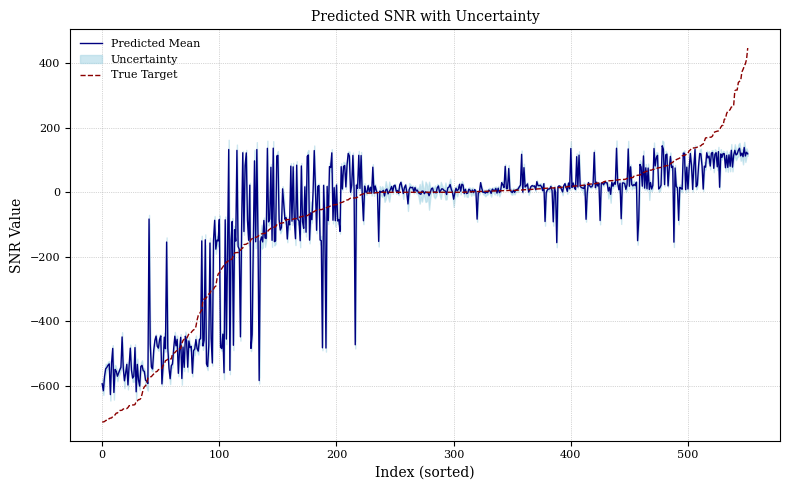

In [25]:
#####################################################################
## Plotting the predicted SNR with uncertainty
#####################################################################

preds_mean = result['ensemble_metrics']['mean_preds']
preds_std = result['ensemble_metrics']['std_preds']
trgts = result['ensemble_metrics']['targets']

# Sort by true target
sorted_idx = np.argsort(trgts)
sorted_mean = preds_mean[sorted_idx]
sorted_std = np.nan_to_num(preds_std[sorted_idx], nan=1e-6, posinf=1e-6, neginf=1e-6)
sorted_targets = trgts[sorted_idx]

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})

fig, ax = plt.subplots(figsize=(8, 5)) 
ax.plot(sorted_mean, label='Predicted Mean', color='navy', linewidth=1)
ax.fill_between(
    range(len(sorted_mean)),
    sorted_mean - sorted_std,
    sorted_mean + sorted_std,
    color='lightblue',
    alpha=0.6,
    label='Uncertainty'
)
ax.plot(sorted_targets, label='True Target', linestyle='--', color='darkred', linewidth=1)

ax.set_xlabel("Index (sorted)")
ax.set_ylabel("SNR Value")
ax.set_title("Predicted SNR with Uncertainty", fontsize=10)
ax.legend(loc='upper left', frameon=False)
ax.grid(True, linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()


In [26]:
##################################################
## Selecting the best model 
##################################################

best_model = models[result['best_model_index']]
data = get_dataset()

## Causal Interventions / counterfactual Inferences

### Scenario1: Classification =  BiNPs 50nm, SNR = -712.1828413. What is the SNR value if the agents are Iodine and BiNPs 100nm?

In [27]:
condition1 = lambda row: row['Classification'] == 'BiNPs 50nm' and row['SNR'] == -712.1828413
agent_list1 = ['Iodine', 'BiNPs 100nm']
intervene(
    data=data,
    model=best_model,
    condition=condition1,
    fact_format="list",
    agent_names=['Iodine', 'BiNPs 100nm'] ,
    cf_ind=False
)


********************************************************************
Original Voltage : 100
Original Time : 215
Original Contrast Agent : BiNPs 50nm
Original SNR : -712.182861328125
********************************************************************
List of New agents: ['Iodine', 'BiNPs 100nm']
************************** Intervention *****************************
Agent : Iodine, Intervened SNR : 14.557262420654297
************************** Intervention *****************************
Agent : BiNPs 100nm, Intervened SNR : 71.21627807617188
********************************************************************


In [28]:
intervene(
    data=data,
    model=best_model,
    condition=condition1,
    fact_format="list",
    agent_names=['Iodine', 'BiNPs 100nm'] ,
    cf_ind=True
)

********************************************************************
Original Voltage : 100
Original Time : 215
Original Contrast Agent : BiNPs 50nm
Original SNR : -712.182861328125
********************************************************************
List of New agents: ['Iodine', 'BiNPs 100nm']
********************* Counterfactual Inference **********************
Agent : Iodine, CounterFactual SNR : -22.972949981689453
********************* Counterfactual Inference **********************
Agent : BiNPs 100nm, CounterFactual SNR : -78.28469848632812
********************************************************************


### Scenario2: Classification =  Iodine, Voltage = 80, SNR = -0.068675075. What is the SNR value if the voltage values are 100, 120, 140

In [29]:
condition2 = lambda row: row['Classification'] == 'Iodine' and row['SNR'] == -0.068675075
voltage_list = [1, 2, 3]
intervene(
    data=data,
    model=best_model,
    condition=condition2,
    fact_format="list",
    voltage_values=voltage_list,
    cf_ind=False
)


********************************************************************
Original Voltage : 80
Original Time : 215
Original Contrast Agent : Iodine
Original SNR : -0.06867507845163345
********************************************************************
List of New Voltage values:
100
120
140
************************** Intervention *****************************
Voltage : 100, Intervened SNR : 14.790735244750977
************************** Intervention *****************************
Voltage : 120, Intervened SNR : 2.3397436141967773
************************** Intervention *****************************
Voltage : 140, Intervened SNR : -7.536026954650879
********************************************************************


In [30]:
intervene(
    data=data,
    model=best_model,
    condition=condition2,
    fact_format="list",
    voltage_values=voltage_list,
    cf_ind=True
)


********************************************************************
Original Voltage : 80
Original Time : 215
Original Contrast Agent : Iodine
Original SNR : -0.06867507845163345
********************************************************************
List of New Voltage values:
100
120
140
********************* Counterfactual Inference **********************
Voltage : 100, CounterFactual SNR : 7.339162826538086
********************* Counterfactual Inference **********************
Voltage : 120, CounterFactual SNR : -4.088099956512451
********************* Counterfactual Inference **********************
Voltage : 140, CounterFactual SNR : -1.7813730239868164
********************************************************************


### Scenario3: Classification = BiNPs 100nm, Voltage= 120, Time= 430, SNR = -0.337925792. What is the SNR value if agent = Iodine , Voltage = 100, Time = 215

In [31]:
condition3 = lambda row: row['Classification'] == 'BiNPs 100nm' and row['SNR'] == -0.337925792
new_dict = {
        'new_voltage': 2,       
        'new_time': 0,          
        'agent': 'Iodine'       
    }
intervene(
    data=data,
    model=best_model,
    condition=condition3,
    fact_format="dict",
    latent_dict=new_dict,
    cf_ind=False
)


********************************************************************
Original Voltage : 120
Original Time : 430
Original Contrast Agent : BiNPs 100nm
Original SNR : -0.3379257917404175
********************************************************************
New Voltage : 120
New Time : 215
New Contrast Agent : Iodine
************************** Intervention *****************************
Intervened SNR : -13.342683792114258


In [32]:
intervene(
    data=data,
    model=best_model,
    condition=condition3,
    fact_format="dict",
    latent_dict=new_dict,
    cf_ind=True
)

********************************************************************
Original Voltage : 120
Original Time : 430
Original Contrast Agent : BiNPs 100nm
Original SNR : -0.3379257917404175
********************************************************************
New Voltage : 120
New Time : 215
New Contrast Agent : Iodine
********************* Counterfactual Inference **********************
CounterFactual SNR : 31.20363998413086


### Scenario4: Classification = Iodine, Voltage= 140, Time= 430, SNR = 2.402363625. What is the SNR value if agent = BiNPs 100nm , BiNPs 50nm

In [33]:
condition4 = lambda row: row['Classification'] == 'Iodine' and row['SNR'] == 2.402363625
agent_list2 = ['BiNPs 100nm', 'BiNPs 50nm']
intervene(
    data=data,
    model=best_model,
    condition=condition4,
    fact_format="list",
    agent_names=agent_list2 ,
    cf_ind=False
)


********************************************************************
Original Voltage : 140
Original Time : 430
Original Contrast Agent : Iodine
Original SNR : 2.4023635387420654
********************************************************************
List of New agents: ['BiNPs 100nm', 'BiNPs 50nm']
************************** Intervention *****************************


Agent : BiNPs 100nm, Intervened SNR : 130.50704956054688
************************** Intervention *****************************
Agent : BiNPs 50nm, Intervened SNR : -447.44854736328125
********************************************************************


In [34]:
intervene(
    data=data,
    model=best_model,
    condition=condition4,
    fact_format="list",
    agent_names=agent_list2 ,
    cf_ind=True
)


********************************************************************
Original Voltage : 140
Original Time : 430
Original Contrast Agent : Iodine
Original SNR : 2.4023635387420654
********************************************************************
List of New agents: ['BiNPs 100nm', 'BiNPs 50nm']
********************* Counterfactual Inference **********************
Agent : BiNPs 100nm, CounterFactual SNR : -57.05238723754883
********************* Counterfactual Inference **********************
Agent : BiNPs 50nm, CounterFactual SNR : -297.512451171875
********************************************************************


### Scenario5: Classification = BiNPs 100nm, Voltage= 100, Time= 430, SNR = 5.679693523. What is the SNR value if voltage = [80, 120, 140] and time = [215]

In [35]:
condition5 = lambda row: row['Classification'] == 'BiNPs 100nm' and row['SNR'] == 5.679693523
voltage_list1 =[0, 2, 3]
time_list = [0]
intervene(
    data=data,
    model=best_model,
    condition= condition5,
    fact_format="list",
    voltage_values=voltage_list1,
    time_values=time_list,
    cf_ind=False
)

********************************************************************
Original Voltage : 100
Original Time : 430
Original Contrast Agent : BiNPs 100nm
Original SNR : 5.679693698883057
********************************************************************
List of New Voltage values:
80
120
140
************************** Intervention *****************************
Voltage : 80, Intervened SNR : 14.044553756713867
************************** Intervention *****************************
Voltage : 120, Intervened SNR : 113.08567810058594
************************** Intervention *****************************
Voltage : 140, Intervened SNR : 114.16778564453125
List of New Time values: 
215
************************** Intervention *****************************
Time : 215, Intervened SNR : 67.265380859375
********************************************************************


In [36]:
intervene(
    data=data,
    model=best_model,
    condition= condition5,
    fact_format="list",
    voltage_values=voltage_list1,
    time_values=time_list,
    cf_ind=True
)

********************************************************************
Original Voltage : 100
Original Time : 430
Original Contrast Agent : BiNPs 100nm
Original SNR : 5.679693698883057
********************************************************************
List of New Voltage values:
80
120
140
********************* Counterfactual Inference **********************
Voltage : 80, CounterFactual SNR : 38.725093841552734
********************* Counterfactual Inference **********************
Voltage : 120, CounterFactual SNR : 119.99713134765625
********************* Counterfactual Inference **********************
Voltage : 140, CounterFactual SNR : 105.79319763183594
List of New Time values: 
215
********************* Counterfactual Inference **********************
Time : 215, CounterFactual SNR : 102.07412719726562
********************************************************************


### Scenario6: Classification =  BiNPs 50nm, SNR = -712.1828413. What is the SNR value if the CT image is changed with the highest SNR value (400.273348)?

In [37]:
condition6 = lambda row: row['Classification'] == 'BiNPs 50nm' and row['SNR'] == -712.1828413
condition7 = lambda row: row['Classification'] == 'BiNPs 100nm' and row['SNR'] == 400.273348

intervene(
    data=data,
    model=best_model,
    condition= condition6,
    fact_format="list",
    img_condition=condition7,
    img_ind=True,
    cf_ind=False
)

********************************************************************
Original Voltage : 100
Original Time : 215
Original Contrast Agent : BiNPs 50nm
Original SNR : -712.182861328125
********************************************************************
CT Image is intervened /inferred!
************************** Intervention *****************************
Image 0, Intervened SNR: -592.3736572265625
********************************************************************


In [38]:
intervene(
    data=data,
    model=best_model,
    condition= condition6,
    fact_format="list",
    img_condition=condition7,
    img_ind=True,
    cf_ind=True
)

********************************************************************
Original Voltage : 100
Original Time : 215
Original Contrast Agent : BiNPs 50nm
Original SNR : -712.182861328125
********************************************************************
CT Image is intervened /inferred!
********************* Counterfactual Inference **********************
Image 0, Counterfactual SNR: -595.2477416992188
********************************************************************


## Latent Space Extraction and Correlation Analysis:

Below code evaluates the trained model by extracting latent representations from the validation dataset.
 - It first loads the data and moves the model and inputs to the appropriate device (GPU if available). 
 - For each batch, the model encodes the inputs to produce latent means, capturing the learned compressed features. 
 - These latent vectors, along with corresponding metadata (voltage, time, agent indices) and SNR values, are collected and converted to NumPy arrays. 
 - The metadata is then one-hot encoded and combined with SNR values into a DataFrame. 
 - Finally, Pearson correlation coefficients and p-values are computed between each latent dimension and the metadata features. 
 - This correlation analysis reveals how individual latent variables relate to known experimental conditions and the signal-to-noise ratio, providing insight into the model’s internal representations.

In [39]:
###############################################################
# Extracting latent space and performing correlation analysis
###############################################################

best_model.eval()

dataloader,_ = get_data_loaders(seed=42, batch_size=16)

latent_list = []
metadata_list = []
snr_list = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)

with torch.no_grad():
    for batch in dataloader:
        img, voltage_idx, time_idx, agent_idx, snr = batch
        img = img.to(device)
        voltage_idx = voltage_idx.to(device)
        time_idx = time_idx.to(device)
        agent_idx = agent_idx.to(device)

        mu, logvar = best_model.encode(img, voltage_idx, time_idx, agent_idx)
        latent = mu.cpu().numpy()
        latent_list.append(latent)

        metadata_np = torch.stack([voltage_idx, time_idx, agent_idx], dim=1).cpu().numpy()
        metadata_list.append(metadata_np)

        snr_list.append(snr.cpu().numpy())

# Concatenate all batches
latents = np.concatenate(latent_list, axis=0)
metadata = np.concatenate(metadata_list, axis=0)
snr = np.concatenate(snr_list, axis=0)

# Convert metadata indices to DataFrame and one-hot encode
metadata_df = pd.DataFrame(metadata, columns=['voltage_idx', 'time_idx', 'agent_idx'])
metadata_df = pd.get_dummies(metadata_df, columns=['voltage_idx', 'time_idx', 'agent_idx'])
metadata_df['SNR'] = snr

# Compute correlations
correlations = []
latent_dim = latents.shape[1]
for i in range(latent_dim):
    z = latents[:, i]
    corr_dict = {'latent_dim': i}
    for col in metadata_df.columns:
        corr_val, p_val = pearsonr(z, metadata_df[col])
        corr_dict[f'{col}_corr'] = corr_val
        corr_dict[f'{col}_pval'] = p_val
    correlations.append(corr_dict)

corr_df = pd.DataFrame(correlations)

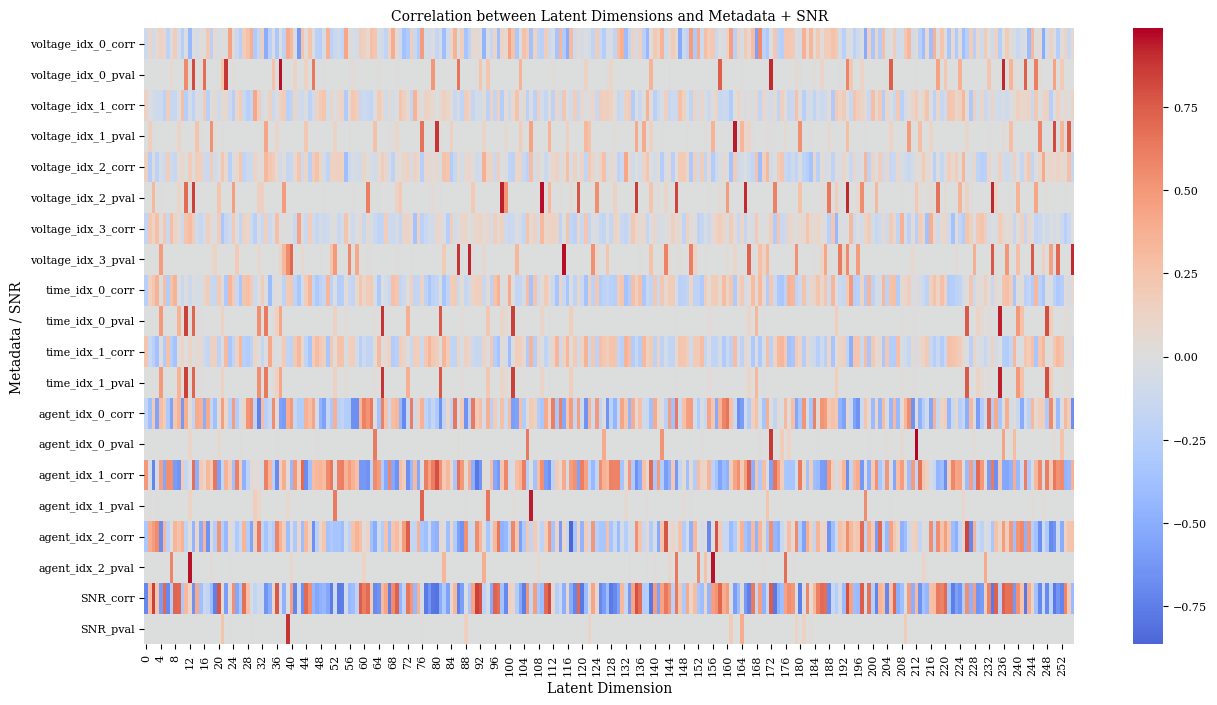

In [40]:
##########################################################################
# Display correlation matrix heatmap (latent dims vs metadata + SNR)
##########################################################################

corr_values = corr_df.drop(columns=['latent_dim']).set_index(corr_df['latent_dim'])
plt.figure(figsize=(15, 8))
sns.heatmap(corr_values.transpose(), cmap='coolwarm', center=0)
plt.title('Correlation between Latent Dimensions and Metadata + SNR')
plt.xlabel('Latent Dimension')
plt.ylabel('Metadata / SNR')
plt.show()


In [44]:
#########################################################################
# Performing correlation analysis for each variable in metadata
#########################################################################

# Choosing a threshold for "strong" correlation
threshold = 0.7

confounders = []

for i, row in corr_df.iterrows():
    # Get SNR correlation
    snr_corr = abs(row['SNR_corr'])

    # Get all metadata correlations (voltage_idx_*, time_idx_*, agent_idx_*)
    metadata_corrs = [v for k, v in row.items() if '_corr' in k and 'SNR' not in k]
    max_meta_corr = max([abs(c) for c in metadata_corrs])

    # Check if both correlations are strong
    if snr_corr > threshold and max_meta_corr > threshold:
        confounders.append((row['latent_dim'], snr_corr, max_meta_corr))

print("Possible Confounder Latent Dimensions:")
for dim, snr_c, meta_c in confounders:
    print(f"Latent {int(dim)} → SNR_corr: {snr_c:.3f}, Metadata_corr: {meta_c:.3f}")


Possible Confounder Latent Dimensions:
Latent 2 → SNR_corr: 0.846, Metadata_corr: 0.720
Latent 80 → SNR_corr: 0.807, Metadata_corr: 0.796
Latent 91 → SNR_corr: 0.847, Metadata_corr: 0.783
Latent 166 → SNR_corr: 0.736, Metadata_corr: 0.730


In [45]:
####################################################################
# Confounder finding in the metadata
####################################################################

voltage_corrs = []
time_corrs = []
agent_corrs = []
confounders = []

threshold = 0.7  # correlation strength threshold

for i, row in corr_df.iterrows():
    snr_corr = abs(row['SNR_corr'])

    # Extract metadata correlations by type
    voltage_corrs_latent = [abs(row[k]) for k in row.keys() if k.startswith('voltage_idx_') and k.endswith('_corr')]
    time_corrs_latent    = [abs(row[k]) for k in row.keys() if k.startswith('time_idx_') and k.endswith('_corr')]
    agent_corrs_latent   = [abs(row[k]) for k in row.keys() if k.startswith('agent_idx_') and k.endswith('_corr')]

    # Max correlation for each group
    max_voltage_corr = max(voltage_corrs_latent) if voltage_corrs_latent else 0
    max_time_corr = max(time_corrs_latent) if time_corrs_latent else 0
    max_agent_corr = max(agent_corrs_latent) if agent_corrs_latent else 0

    # Track correlations
    voltage_corrs.append((row['latent_dim'], snr_corr, max_voltage_corr))
    time_corrs.append((row['latent_dim'], snr_corr, max_time_corr))
    agent_corrs.append((row['latent_dim'], snr_corr, max_agent_corr))

    # Identify confounders for each type
    if snr_corr > threshold and max_voltage_corr > threshold:
        confounders.append((row['latent_dim'], 'voltage', snr_corr, max_voltage_corr))
    if snr_corr > threshold and max_time_corr > threshold:
        confounders.append((row['latent_dim'], 'time', snr_corr, max_time_corr))
    if snr_corr > threshold and max_agent_corr > threshold:
        confounders.append((row['latent_dim'], 'agent', snr_corr, max_agent_corr))

print("Confounders per metadata type:")
for latent_dim, kind, snr_c, meta_c in confounders:
    print(f"Latent {latent_dim} → {kind.upper()} | SNR_corr: {snr_c:.3f}, {kind}_corr: {meta_c:.3f}")


Confounders per metadata type:
Latent 2.0 → AGENT | SNR_corr: 0.846, agent_corr: 0.720
Latent 80.0 → AGENT | SNR_corr: 0.807, agent_corr: 0.796
Latent 91.0 → AGENT | SNR_corr: 0.847, agent_corr: 0.783
Latent 166.0 → AGENT | SNR_corr: 0.736, agent_corr: 0.730


## Visualisation of SNR Values Under Intervention and counterfactual inference Scenarios

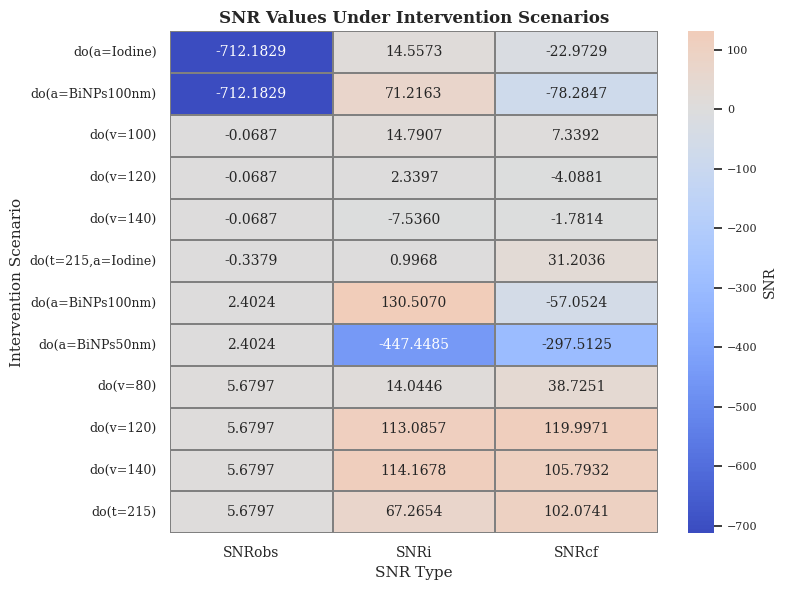

In [43]:
##############################################################################
# Lets visualise the SNR values for different scenarios
##############################################################################

data = {
    'Scenario': [
        'do(a=Iodine)', 'do(a=BiNPs100nm)', 'do(v=100)', 'do(v=120)', 'do(v=140)', 
        'do(t=215,a=Iodine)', 'do(a=BiNPs100nm)', 'do(a=BiNPs50nm)', 'do(v=80)', 
        'do(v=120)', 'do(v=140)', 'do(t=215)'
    ],
    'SNRobs': [-712.1829, -712.1829, -0.0687, -0.0687, -0.0687, -0.3379, 2.4024, 2.4024, 5.6797, 5.6797, 5.6797, 5.6797],
    'SNRi': [14.5573, 71.2163, 14.7907, 2.3397, -7.5360, 0.9968, 130.5070, -447.4485, 14.0446, 113.0857, 114.1678, 67.2654],
    'SNRcf': [-22.9729, -78.2847, 7.3392, -4.0881, -1.7814, 31.2036, -57.0524, -297.5125, 38.7251, 119.9971, 105.7932, 102.0741]
}

# Create DataFrame
df = pd.DataFrame(data).set_index('Scenario')

sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 10,
    "axes.titlesize": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})
plt.figure(figsize=(8, 6))

# Plot heatmap
sns.heatmap(
    df,
    annot=True,
    fmt=".4f",
    cmap="coolwarm",           
    linewidths=0.3,
    linecolor='gray',
    cbar_kws={"label": "SNR"},
    center=0
)

# Axis labels and title
plt.title("SNR Values Under Intervention Scenarios", fontsize=12, weight='bold')
plt.xlabel("SNR Type", fontsize=11)
plt.ylabel("Intervention Scenario", fontsize=11)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()
